In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, deque, defaultdict
from cdlib.classes import NodeClustering
from cdlib import algorithms

def draw_graph(G: nx.Graph, **kwargs):
    plt.title(G.name)
    nx.draw(G, with_labels=True, **kwargs)
    plt.show()

def read_with_clusters(path):
	G = nx.MultiGraph()
	with open(path, 'r') as file:
		line = file.readline()
		n = int(line.strip().split(" ")[1])
		for i in range(n):
			parts = file.readline().strip().split(" ")
			id = int(parts[0])
			label = parts[1]
			cluster_id = int(parts[2])
			G.add_node(id, label=label, cluster=cluster_id)
		line = file.readline()
		m = int(line.strip().split(" ")[1])
		for _ in range(m):
			parts = file.readline().strip().split(" ")
			G.add_edge(int(parts[0]), int(parts[1]))
			
	return G

def distance(G, i):
	D = [-1] * len(G) # D = {}
	Q = deque()
	D[i] = 0
	Q.append(i)
	while Q:
		i = Q.popleft()
		for j in G[i]:
			if D[j] == -1: # if j not in D:
				D[j] = D[i] + 1
				Q.append(j)
	return [d for d in D if d > 0]

def distances(G, n = 100):
	D = []
	approx = G.nodes()
	if len(G) > n:
		approx = random.sample(list(G.nodes()), n)
	for i in approx:
		D.append(distance(G, i))
	return D

def lcc(G: nx.Graph) -> float:
    """relative size of the largest connected component (between 0 and 1)"""
    if G.is_directed(): G = nx.Graph(G)

    return len(max(nx.connected_components(G), key=len)) / len(G)

def distribution(G):
	degrees = np.array(sorted([G.degree(n) for n in G.nodes()], reverse=True))
	count_general = Counter(degrees)
	fig = plt.figure()
	plt.xscale("log")
	plt.yscale("log")
	general_dist = plt.scatter(count_general.keys(), count_general.values(), label="Degrees", s=20)
	plt.xlabel("k")
	plt.ylabel("p(k)")
	plt.legend()
	plt.title(G.name)
	plt.show()
	plt.savefig(f"{G.name}")

def info(G):
	print("{:>20s} | '{:s}'".format('Graph', G.name))
	n = G.number_of_nodes()
	print("{:>20s} | {:,d}".format('Nodes', n))
	m = G.number_of_edges()
	print("{:>20s} | {:,d}".format('Edges', m))
	k = 2*m/n
	print("{:>20s} | {:.2f}".format('Degree', k))
	max_degree = max([G.degree(n) for n in G.nodes()])
	print("{:>20s} | {:.2f}".format('Max node degree', max_degree))
	cc = lcc(G)
	print("{:>20s} | {:.2f}".format('LCC', cc))
	G2 = G
	if type(G2) == nx.MultiGraph:
		G2 = nx.Graph(G)
	dis = [i for d in distances(G2) for i in d]
	print("{:>20s} | {:.2f} ({:,d})".format('Distance', sum(dis) / len(dis), max(dis)))
	density = k/(n-1)
	print("{:>20s} | {:.9f}".format('Density', density))
	clustering = nx.average_clustering(G)
	print("{:>20s} | {:.9f}".format('Clustering', clustering))
	distribution(G)

def top_nodes(G: nx.Graph, C: dict[any, float], centrality: str, n=15) -> dict[any]:
    """prints and returns top n nodes by given measure of centrality"""

    # OPT take callable instead of dict, only compute centrality on non-mode nodes
    # OPT np.argpartition instead of sort
    print("{:>12s} | '{:s}'".format('Centrality', centrality))
    nodes = []
    for i, c in sorted(C.items(), key=lambda item: (item[1], G.degree[item[0]]), reverse=True):
        if not G.nodes[i]['label'].startswith('m-'):
            nodes.append(G.nodes[i])
            print("{:>12.6f} | '{:s}' ({:,d})".format(
                c, G.nodes[i]['label'], G.degree[i]))
            n -= 1
            if n == 0:
                break
    print()
    return nodes
def actor_names(nodes) -> list[str]:
    """Parses labels of nodes in collaboration_imdb.net into
    a nicer format. Try pasting the ouput of this function into
    chatGPT if you have trouble classifying the actors."""
    names = []
    for n in nodes:
        try:
            last, fst = n["label"].split(", ")
            if fst[-1] == ')':
                fst = fst[:fst.index('(') - 1]

            names.append(f"{fst} {last}")
        except ValueError: # failed unpacking
            names.append(n["label"])

    return names
def random_walk(G):
	n = G.number_of_nodes()
	visited = set([])
	current = random.sample(list(G.nodes()), 1)[0]
	while len(visited)/n < 0.15:
		visited.add(current)
		current = random.sample(list(G[current]), 1)[0]
	
	return nx.convert_node_labels_to_integers(nx.Graph(nx.induced_subgraph(G, visited)))

def eigenvector_centrality(G, eps = 1e-6):
    # Initialize eigenvector centrality score
    E = [1] * G.number_of_nodes()
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores
        U = [sum([E[j] for j in G[i]]) for i in G.nodes()]
        # Normalize scores
        u = sum(U)
        U = [U[i] * len(G) / u for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(E[i] - U[i]) for i in G.nodes()])
        # Use the new scores for the next iteration
        E = U
    return {i: E[i] for i in range(len(E))}

In [ ]:
# Prva naloga
G = nx.convert_node_labels_to_integers(read_with_clusters("dolphins.net"), label_attribute=None)
#degree_centrality = top_nodes(G, nx.degree_centrality(G), 'centrality')
#clustering = top_nodes(G, nx.clustering(G), 'clustering')

#mi_corrected_clustering = {i: c * (G.degree(i) - 1) for i, c in nx.clustering(G).items()}
#mi_corrected(G, mi_corrected_clustering, 'mi corrected clustering')
#pagerank_cent = top_nodes(G, nx.pagerank(G), 'pagerank')
#closeness_cent = top_nodes(G, nx.closeness_centrality(G), 'closeness')
betweenness_cent = top_nodes(G, nx.betweenness_centrality(G), 'betweenness')

In [ ]:
# Druga naloga
network =  'social'
file = f"{network}.net"
G = nx.Graph(nx.convert_node_labels_to_integers(nx.read_pajek(file)))
G.name = "Original social network"
info(G)
SG = nx.Graph(random_walk(G))
SG.name = "Induced social network"
info(SG)

In [69]:

def generate_gn(mi = 0.1):
    G = nx.MultiGraph(name="girvan_newman")
    for i in range(72):
        G.add_node(i, cluster=i // 24 + 1)
    for i in range(72):
        for j in range(i+1, 72):
            if G.nodes[i]['cluster'] == G.nodes[j]['cluster']:
                if random.random() < 20*(1-mi)/23:
                    G.add_edge(i,j)
            else:
                if random.random() < 5*mi/18:
                    G.add_edge(i,j)
    return G

def known_clustering(G: nx.Graph, cluster_attr="value") -> NodeClustering:
    """Extracts known node clustering from their attrubute with supplied name."""

    C = defaultdict(list)
    for i, d in G.nodes(data=True):
        C[d[cluster_attr]].append(i)

    return NodeClustering(list(C.values()), G, "Known")
    #return list(C.values())


def CD_comparison(G: nx.Graph, algs, runs=1) -> None:
    """Compare quality of community-detection algorithms on G.
    Algorithms must conform to the cdlib format (returning a NodeClustering object)."""
    K = known_clustering(G)

    print("{:>12s} | {:5s} {:^6s}  {:^5s}  {:^5s}  {:^5s}".format(
        'Algorithm', 'Count', 'Q', 'NMI', 'ARI', 'VI'))

    for alg in algs:
        s, Q, NMI, ARI, VI = 0, 0, 0, 0, 0

        for _ in range(runs):
            C = algs[alg](G)
            s += len(C.communities) / runs # C.communities is a list of lists of node IDs
            Q += C.newman_girvan_modularity().score / runs
            NMI += K.normalized_mutual_information(C).score / runs
            ARI += K.adjusted_rand_index(C).score / runs
            VI += K.variation_of_information(C).score / runs

        print("{:>12s} | {:>5.0f} {:6.3f}  {:5.3f}  {:5.3f}  {:5.3f}".format(
            '\'' + alg + '\'', s, Q, NMI, ARI, VI))
    print()


def fast_label_propagation(G):
    assert (type(G) == nx.MultiGraph)

    N = list(G.nodes())
    random.shuffle(N)

    Q = deque(N)
    S = [True] * len(G)

    C = [i for i in range(len(G))]

    while Q:
        i = Q.popleft()
        S[i] = False

        if len(G[i]) > 0:
            L = {}
            for j in G[i]:
                if C[j] not in L:
                    L[C[j]] = 0
                L[C[j]] += len(G[i][j])

            maxl = max(L.values())
            c = random.choice([c for c in L if L[c] == maxl])

            if C[i] != c:
                C[i] = c

                for j in G[i]:
                    if C[j] != c and not S[j]:
                        Q.append(j)
                        S[j] = True

    L = {}
    for i in N:
        if C[i] in L:
            L[C[i]].append(i)
        else:
            L[C[i]] = [i]

    return NodeClustering(list(L.values()), G)


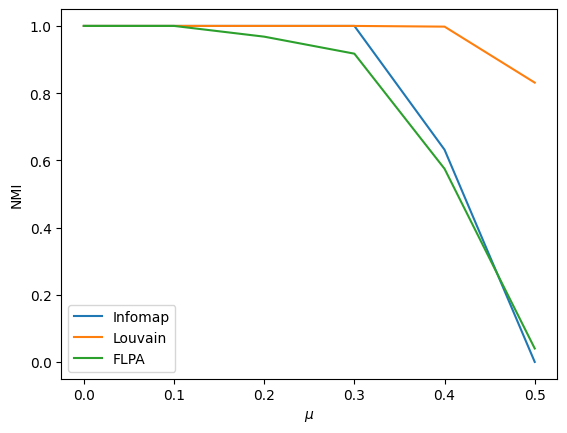

In [70]:
iters = 25
algs = {"Infomap": algorithms.infomap, "Louvain": algorithms.louvain,
        "FLPA": fast_label_propagation}
res = {alg: [] for alg in algs.keys()}
mis = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure()
for alg in algs:
    for mi in mis:
        nmi = 0
        for _ in range(iters):
            G = nx.MultiGraph(generate_gn(mi))
            K = known_clustering(G, cluster_attr='cluster')
            C = algs[alg](G)
            nmi += K.normalized_mutual_information(C).score
        nmi /= iters
        res[alg].append(nmi)
    plt.plot(mis, res[alg], label=alg)

plt.xlabel('$\mu$')
plt.ylabel('NMI')
plt.legend()


WHOLE/LFR_00_0.net
WHOLE/LFR_00_1.net
WHOLE/LFR_00_2.net
WHOLE/LFR_00_3.net
WHOLE/LFR_00_4.net
WHOLE/LFR_00_5.net
WHOLE/LFR_00_6.net
WHOLE/LFR_00_7.net
WHOLE/LFR_00_8.net
WHOLE/LFR_00_9.net
WHOLE/LFR_00_10.net
WHOLE/LFR_00_11.net
WHOLE/LFR_00_12.net
WHOLE/LFR_00_13.net
WHOLE/LFR_00_14.net
WHOLE/LFR_00_15.net
WHOLE/LFR_00_16.net
WHOLE/LFR_00_17.net
WHOLE/LFR_00_18.net
WHOLE/LFR_00_19.net
WHOLE/LFR_00_20.net
WHOLE/LFR_00_21.net
WHOLE/LFR_00_22.net
WHOLE/LFR_00_23.net
WHOLE/LFR_00_24.net
WHOLE/LFR_02_0.net
WHOLE/LFR_02_1.net
WHOLE/LFR_02_2.net
WHOLE/LFR_02_3.net
WHOLE/LFR_02_4.net
WHOLE/LFR_02_5.net
WHOLE/LFR_02_6.net
WHOLE/LFR_02_7.net
WHOLE/LFR_02_8.net
WHOLE/LFR_02_9.net
WHOLE/LFR_02_10.net
WHOLE/LFR_02_11.net
WHOLE/LFR_02_12.net
WHOLE/LFR_02_13.net
WHOLE/LFR_02_14.net
WHOLE/LFR_02_15.net
WHOLE/LFR_02_16.net
WHOLE/LFR_02_17.net
WHOLE/LFR_02_18.net
WHOLE/LFR_02_19.net
WHOLE/LFR_02_20.net
WHOLE/LFR_02_21.net
WHOLE/LFR_02_22.net
WHOLE/LFR_02_23.net
WHOLE/LFR_02_24.net
WHOLE/LFR_04_0.net
W

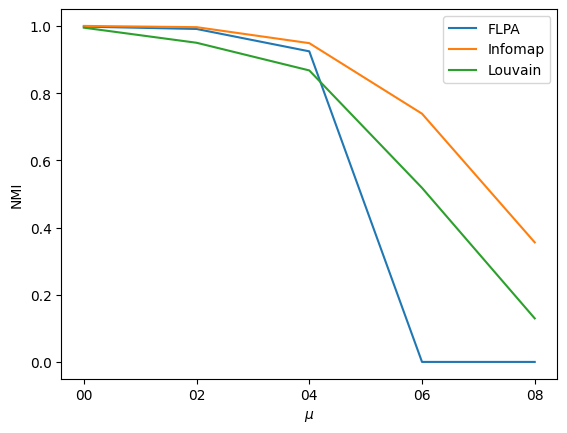

In [71]:
iters = 25
algs = {"FLPA": fast_label_propagation, "Infomap": algorithms.infomap, "Louvain": algorithms.louvain}
res = {alg: [] for alg in algs.keys()}
mis = ["00", "02", "04", "06", "08"]

plt.figure()
for alg in algs:
    for mi in mis:
        nmi = 0
        for i in range(iters):
            netpath = f"WHOLE/LFR_{mi}_{i}.net"
            print(netpath)
            G = nx.convert_node_labels_to_integers(read_with_clusters(netpath))
            K = known_clustering(G, cluster_attr='cluster')
            C = algs[alg](G)
            nmi += K.normalized_mutual_information(C).score
        nmi /= iters
        res[alg].append(nmi)
    plt.plot(mis, res[alg], label=alg)

plt.xlabel('$\mu$')
plt.ylabel('NMI')
plt.legend()

FLPA, 8, 0
FLPA, 8, 1
FLPA, 8, 2
FLPA, 8, 3
FLPA, 8, 4
FLPA, 8, 5
FLPA, 8, 6
FLPA, 8, 7
FLPA, 8, 8
FLPA, 8, 9
FLPA, 8, 10
FLPA, 8, 11
FLPA, 8, 12
FLPA, 8, 13
FLPA, 8, 14
FLPA, 8, 15
FLPA, 8, 16
FLPA, 8, 17
FLPA, 8, 18
FLPA, 8, 19
FLPA, 8, 20
FLPA, 8, 21
FLPA, 8, 22
FLPA, 8, 23
FLPA, 8, 24
FLPA, 16, 0
FLPA, 16, 1
FLPA, 16, 2
FLPA, 16, 3
FLPA, 16, 4
FLPA, 16, 5
FLPA, 16, 6
FLPA, 16, 7
FLPA, 16, 8
FLPA, 16, 9
FLPA, 16, 10
FLPA, 16, 11
FLPA, 16, 12
FLPA, 16, 13
FLPA, 16, 14
FLPA, 16, 15
FLPA, 16, 16
FLPA, 16, 17
FLPA, 16, 18
FLPA, 16, 19
FLPA, 16, 20
FLPA, 16, 21
FLPA, 16, 22
FLPA, 16, 23
FLPA, 16, 24
FLPA, 24, 0
FLPA, 24, 1
FLPA, 24, 2
FLPA, 24, 3
FLPA, 24, 4
FLPA, 24, 5
FLPA, 24, 6
FLPA, 24, 7
FLPA, 24, 8
FLPA, 24, 9
FLPA, 24, 10
FLPA, 24, 11
FLPA, 24, 12
FLPA, 24, 13
FLPA, 24, 14
FLPA, 24, 15
FLPA, 24, 16
FLPA, 24, 17
FLPA, 24, 18
FLPA, 24, 19
FLPA, 24, 20
FLPA, 24, 21
FLPA, 24, 22
FLPA, 24, 23
FLPA, 24, 24
FLPA, 32, 0
FLPA, 32, 1
FLPA, 32, 2
FLPA, 32, 3
FLPA, 32, 4
FLPA, 32, 5
FLPA, 32

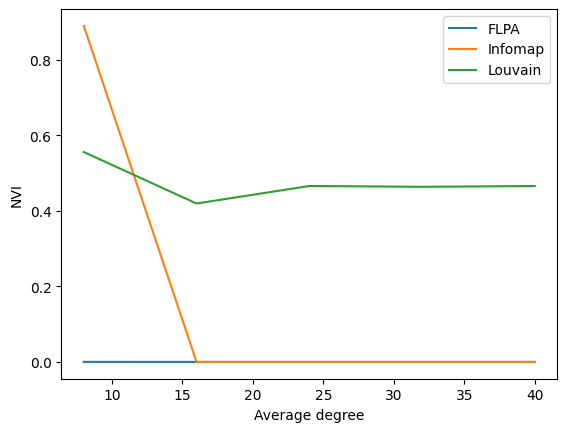

In [66]:
iters = 25
n = 1000
algs = {"FLPA": fast_label_propagation, "Infomap": algorithms.infomap, "Louvain": algorithms.louvain}
res = {alg: [] for alg in algs.keys()}
degrees = [8, 16, 24, 32, 40]

plt.figure()
for alg in algs:
    for deg in degrees:
        print(f"{alg}, {deg}")
        nvi = 0
        for i in range(iters):
            G = nx.MultiGraph(nx.gnm_random_graph(n, deg*n/2))
            cc = nx.connected_components(G)
            K = NodeClustering(list(cc), G)
            #K = known_clustering(G, cluster_attr='cluster')
            C = algs[alg](G)
            nvi += K.variation_of_information(C).score / np.log(n)
        nvi /= iters
        res[alg].append(nvi)
    plt.plot(degrees, res[alg], label=alg)

plt.xlabel('Average degree')
plt.ylabel('NVI')
plt.legend()

FLPA, 8
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
1
FLPA, 16
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
FLPA, 24
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
FLPA, 32
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
FLPA, 40
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Infomap, 8
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
2
1
1
2
1
1
Infomap, 16
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Infomap, 24
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Infomap, 32
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Infomap, 40
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Louvain, 8
1
2
2
1
2
1
1
2
1
1
1
1
2
2
2
1
1
1
1
2
1
1
1
1
2
Louvain, 16
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Louvain, 24
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Louvain, 32
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Louvain, 40
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


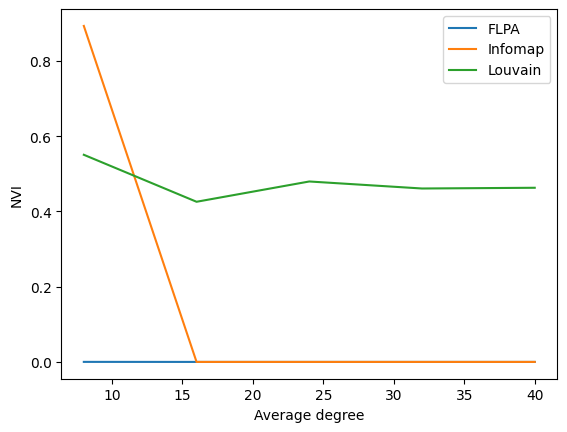